# Assignment 3 - Customer Segmentation
## Author - Salinee Kingbaisomboon
### UW NetID: 1950831

## Instructions
1. Read dataset
2. Calculate the Recency, Frequency, Monitory for each customer
3. Using K-means algorithm, perform customer segmentation
4. Describe your results

In [1]:
# Load necessary libraries
import datetime as dt
import pandas as pd
import numpy as np
from collections import OrderedDict
import sklearn.preprocessing as sk
import seaborn as sns

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore") # To suppress warning

%matplotlib inline

pd.options.display.max_rows = None

In [2]:
# Load data
filename = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv'
df = pd.read_csv(filename)
# Described DataFrame
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [3]:
# Convert Order Date to Datetime Object
df["Timestamp"] = pd.to_datetime(df["Order Date"], format='%m/%d/%Y')
print("Minimal Date=%s, Maximal Date=%s"%(min(df["Timestamp"]).strftime("%Y-%m-%d"), \
                                          max(df["Timestamp"]).strftime("%Y-%m-%d")))

Minimal Date=2014-01-03, Maximal Date=2017-12-30


In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Timestamp
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016-11-08
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016-11-08
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016-06-12
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015-10-11
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015-10-11


In [5]:
# Print DataFrame's size
print(df.shape)
# Print DataFrame's data types
print(df.dtypes)

(9994, 22)
Row ID                    int64
Order ID                 object
Order Date               object
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
Timestamp        datetime64[ns]
dtype: object


In [6]:
# Calculate RFM Features for Customers at each Checkpoint (whole month of December 2017 in this assignment)
Start_Date_Obj = dt.datetime.strptime("1/1/2017", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("1/30/2017", "%m/%d/%Y")
Time_Window = 60 #days. Only consider customers who have activities within the recent 60 days
FM_Window = 7 #days for frequency and monetary

check_point_date = Start_Date_Obj
CustomerID = []
Checkpoint = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []

while check_point_date <= End_Date_Obj:
    window_start = check_point_date - dt.timedelta(days = Time_Window)
    mask = (df["Timestamp"] >= window_start) & (df["Timestamp"] < check_point_date)
    # Get the data in [checkpoint-60days, checkpoint]
    data_checkpoint = df.loc[mask]
    # Get the ids of customers who have activities in [checkpoint-60days, checkpoint]
    unique_customers = list(set(data_checkpoint["Customer ID"]))
    print(f'There are {len(unique_customers)} unique customers on date: {str(check_point_date)}')
    FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
    for customer in unique_customers:
        CustomerID.append(customer)
        Checkpoint.append(check_point_date)
        mask = data_checkpoint["Customer ID"] == customer
        data_checkpoint_customer = data_checkpoint.loc[mask]
        delta = check_point_date - max(data_checkpoint_customer["Timestamp"])
        recency = delta.days # Recency, days between checkpoint and last transaction time
        mask = data_checkpoint_customer["Timestamp"] >= FM_Window_Start
        data_checkpoint_customer_fm = data_checkpoint_customer.loc[mask]
        frequency = data_checkpoint_customer_fm.shape[0]
        value = np.sum(data_checkpoint_customer_fm["Profit"]) # monetary values (profit in this assignment)
        quantity = np.sum(data_checkpoint_customer_fm["Quantity"])# monetary quantity
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
    check_point_date = check_point_date + dt.timedelta(days = 1)

# Consolidate all columns into a signle data frame
RFM_Dict = OrderedDict([ ('CustomerID', CustomerID),
          ('Checkpoint', Checkpoint),
          ('Recency',  Recency),
          ('Frequency', Frequency),
          ('Value', Monetary_Value),
          ('Quantity', Monetary_Quantity)] )
RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)
RFM_Frame.head()

There are 287 unique customers on date: 2017-01-01 00:00:00
There are 291 unique customers on date: 2017-01-02 00:00:00
There are 289 unique customers on date: 2017-01-03 00:00:00
There are 283 unique customers on date: 2017-01-04 00:00:00
There are 278 unique customers on date: 2017-01-05 00:00:00
There are 277 unique customers on date: 2017-01-06 00:00:00
There are 269 unique customers on date: 2017-01-07 00:00:00
There are 269 unique customers on date: 2017-01-08 00:00:00
There are 269 unique customers on date: 2017-01-09 00:00:00
There are 259 unique customers on date: 2017-01-10 00:00:00
There are 252 unique customers on date: 2017-01-11 00:00:00
There are 248 unique customers on date: 2017-01-12 00:00:00
There are 245 unique customers on date: 2017-01-13 00:00:00
There are 237 unique customers on date: 2017-01-14 00:00:00
There are 238 unique customers on date: 2017-01-15 00:00:00
There are 240 unique customers on date: 2017-01-16 00:00:00
There are 241 unique customers on date: 

,CustomerID,Checkpoint,Recency,Frequency,Value,Quantity
0,MJ-17740,2017-01-01,55,0,0.00,0
1,RW-19630,2017-01-01,19,0,0.00,0
2,RD-19720,2017-01-01,29,0,0.00,0
3,SH-19975,2017-01-01,6,1,3.51,2
4,JM-15265,2017-01-01,21,0,0.00,0


In [7]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
RFM_Frame['Recency'] = [neg_to_zero(x) for x in RFM_Frame.Recency]
RFM_Frame['Frequency'] = [neg_to_zero(x) for x in RFM_Frame.Frequency]
RFM_Frame['Value'] = [neg_to_zero(x) for x in RFM_Frame.Value]
RFM_Frame['Quantity'] = [neg_to_zero(x) for x in RFM_Frame.Quantity]

# unskew the data
RFM_Frame_log = RFM_Frame[['Recency', 'Frequency', 'Value', 'Quantity']].apply(np.log, axis = 1).round(3)

In [8]:
# scale the data
scaler = sk.StandardScaler()
RFM_Frame_scaled = scaler.fit_transform(RFM_Frame_log)

In [9]:
# transform into a dataframe
RFM_Frame_scaled = pd.DataFrame(RFM_Frame_scaled, index = RFM_Frame.index, columns = RFM_Frame_log.columns)

In [10]:
RFM_Frame_scaled.head()

,Recency,Frequency,Value,Quantity
0,0.896460,-0.17669,-0.206972,-0.249959
1,-0.489120,-0.17669,-0.206972,-0.249959
2,0.062244,-0.17669,-0.206972,-0.249959
3,-1.990708,-0.17669,1.222059,1.121136
4,-0.357471,-0.17669,-0.206972,-0.249959


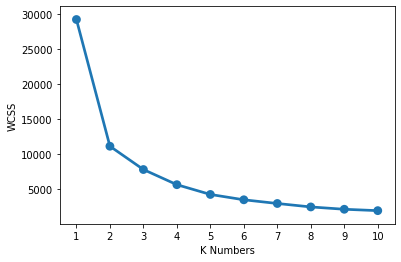

In [11]:
# the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(RFM_Frame_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [12]:
# Perform K-Means with sklearn using Recency, Frequency, Value and Quantity attributes
k = 3 # Pick 3 from above Elbow method, somewhere WSS dramatically decrease but not too much K
X = pd.DataFrame(RFM_Frame_scaled,columns=['Recency', 'Frequency', 'Value']) # generated a new data frame for k-means
kmeans = KMeans(n_clusters=k).fit(RFM_Frame_scaled)
Labels = ['Low Value', 'Mid value', 'High Value']
ClusterCentroids = kmeans.cluster_centers_ # get coordinates of cluster centers

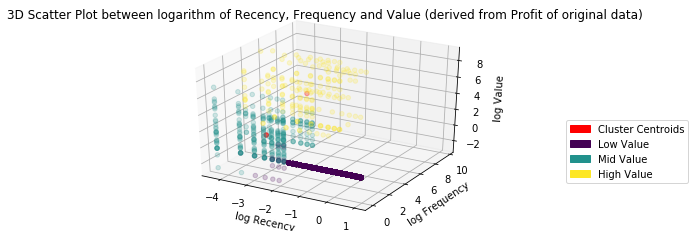

In [13]:
# Plot 3D Scatter Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X.loc[:, 'Recency']
ys = X.loc[:, 'Frequency']
zs = X.loc[:, 'Value']
sc = ax.scatter(xs, ys, zs, c=kmeans.labels_.astype(int), alpha=0.2)

ax.scatter(ClusterCentroids[:, 0], ClusterCentroids[:, 1], ClusterCentroids[:, 2], c='red')
ax.set_xlabel('log Recency')
ax.set_ylabel('log Frequency')
ax.set_zlabel('log Value')
# Add legend for the Cluster Centroids
red_legend = mpatches.Patch(color='red', label='Cluster Centroids')
# Add legend for the label's color
purple_legend = mpatches.Patch(color=sc.cmap(sc.norm(0)), label='Low Value')
green_legend = mpatches.Patch(color=sc.cmap(sc.norm(1)), label='Mid Value')
yellow_legend = mpatches.Patch(color=sc.cmap(sc.norm(2)), label='High Value')
plt.legend(handles=[red_legend, purple_legend, green_legend, yellow_legend], loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.title('3D Scatter Plot between logarithm of Recency, Frequency and Value (derived from Profit of original data)')
plt.show()

***
**Summary:**
1. I perform **Recency, Frequency, and Monetary (RFM)** technique to do the <font color=blue>**Customer Segmentation**</font> analysis.
2. After reading data and convert **Order Date** to **Datetime object**:
    - Minimal Date of the data set is **2014-01-03**
    - Maximal Date of the data set is **2017-12-30**
3. **Recency** means how much time has elapsed since a customer’s last order. Therefore the smaller the value is, the more engaged a customer to that brand.
    - We can see from the **3D Scatter Plot** that:
        - The highest amount of customers are in the **Mid Value**
        - The mid-range amount of customers are in the **High Value**
        - The least amount of customers are in the **Low Value**
        - **Note:** Value is **Profit** from the original data set.
4. We can conclude that 
    - Majority of the customer's group of this retail store's data set generate <font color=green>**mid-range profit**</font> to the store.
    - The second rank of the customer's group in term of amount are generated <font color=brown>**high profit**</font> to the store.
    - The last group of customers generate <font color=red>**low profit**</font> to the store. This is the only group that has bigger range of **recency** value which mean they tend to spend money on the retail store not very often compared with other two's group. (That's why they generate low profit to the store).
        
***